In [1]:
import requests
import json
import traceback
import feedparser
import time
import argparse
import os
#import google.auth.transport.requests
#import google.oauth2.credentials

from random import randint
#from PIL import Image, ImageTk
from os import path
from glob import glob
#from google.assistant.library import Assistant
#from google.assistant.library.event import EventType
#from google.assistant.library.file_helpers import existing_file
import dropbox

## Dropbox

In [13]:
try:
    with open('./data/weatherapi.key', 'r') as f:
        weather_api_token = f.readlines()[0].strip('\n')
    print weather_api_token
except:
    print 'Could not find weather api key file'
    print 'Create an account at https://darksky.net/dev/ and create a file at ./data/weatherapi.key with the api key value written in it'
try:
    with open('./data/dropboxapi.key', 'r') as f:
        dropbox_api_token = f.readlines()[0]
        print dropbox_api_token
except:
    print 'Could not find dropbox api key file'
    print 'Create a developer account and create a file at ./data/dropboxapi.key with the api key value written in it'

ed8a0ac81cf771b079749c5f046277c4
uj3NVv0lXYcAAAAAAABjNkx4-yLhn6AiTTIjpd7NZrSTRUbWpwiOjAxOCdS0a2wE


In [14]:
dbx = dropbox.Dropbox(dropbox_api_token)

In [15]:
picfolder = './data/photos/'
pics = [f for f in glob(picfolder+'*') if not path.isdir(f)]
pics

['./data/photos/Screenshot 2018-05-01 at 13.26.17.png',
 './data/photos/Screenshot 2018-05-01 at 13.26.32.png',
 './data/photos/Screenshot 2018-05-01 at 12.43.53.png',
 './data/photos/Screenshot 2018-05-01 at 13.24.48.png',
 './data/photos/Screenshot 2018-05-01 at 12.47.07.png']

In [7]:
files = dbx.files_list_folder('/MirrorPics')
remote_files = [f.name for f in files.entries]
local_files = [path.basename(f) for f in glob('./data/photos/*') if not path.isdir(f)]
for f in remote_files:
    if f not in local_files:
        dbx.files_download_to_file('./data/photos/%s'%f, '/MirrorPics/%s'%f)
        print 'Downloaded %s'%f
for f in local_files:
    if f not in remote_files:
        os.remove('./data/photos/%s'%f)
        print 'Removed %s'%f

Removed Screenshot 2018-05-01 at 13.24.28.png


## Google OAuth

## photos

In [2]:
import numpy
import matplotlib
from matplotlib.pyplot import imshow

In [3]:
def histeq(im,nbr_bins=256):
    # get image histogram
    imhist,bins = numpy.histogram(im.flatten(),nbr_bins,normed=True)
    cdf = imhist.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    im2 = numpy.interp(im.flatten(),bins[:-1],cdf)

    return im2.reshape(im.shape), cdf

In [4]:
pics = glob('./data/photos/*')
rot = {1 : 0, 3 : 180, 6 : 270, 8 : 90}
image = Image.open(pics[40])

Rotated by 270 degrees


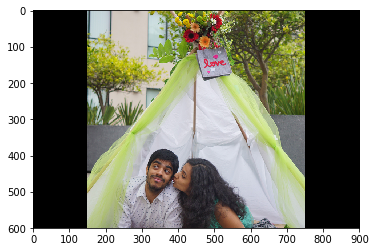

In [4]:
ori = image._getexif().get(274, 1)
w, h = image.size
wnew, hnew = int(w*600./h), 600
image = image.resize((wnew, hnew), Image.ANTIALIAS)
image = image.rotate(rot.get(ori, 0))
print 'Rotated by %d degrees'%(rot.get(ori, 0))
image = image.convert('RGB')
imshow(image)

In [5]:
imageBW = image.convert('L')
matplotlib.pyplot.gray()
imshow(numpy.array(imageBW))

In [6]:
matplotlib.pyplot.contour(imageBW, origin='image')

In [7]:
im2,cdf = histeq(numpy.array(imageBW))
imshow(im2)

## working with the assistant library

In [2]:
DEVICE_API_URL = 'https://embeddedassistant.googleapis.com/v1alpha2'
DEVICE_MODEL_ID = 'MagicMirror2'
credfile = './resources/google_cred.json'

In [3]:
with open(credfile, 'r') as f:
    credentials = google.oauth2.credentials.Credentials(token=None, **json.load(f))

In [4]:
def process_event(event, device_id):
    """Pretty prints events.
    Prints all events that occur with two spaces between each new
    conversation and a single space between turns of a conversation.
    Args:
        event(event.Event): The current event to process.
    """
    if event.type == EventType.ON_CONVERSATION_TURN_STARTED:
        print 'Listening...'
    if event.type == EventType.ON_RECOGNIZING_SPEECH_FINISHED:
        print event
    if (event.type == EventType.ON_RESPONDING_FINISHED):
        print 'Done'

In [ ]:
with Assistant(credentials, DEVICE_MODEL_ID) as assistant:
    events = assistant.start()
    for event in events:
        process_event(event, assistant.device_id)

## working with image icons

In [3]:
image = Image.open('./resources/weather_icons/partly-cloudy-day.png')
image = image.resize((90, 90), Image.ANTIALIAS)

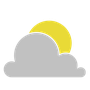

In [4]:
image

## working with darksky weather api

In [2]:
with open('data/weatherapi.key', 'r') as f:
    weather_api_token = (f.readlines()[0]).strip('\n')
with open('data/locationapi.key', 'r') as f:
    location_api_token = (f.readlines()[0]).strip('\n')
weather_lang = 'en' # see https://darksky.net/dev/docs/forecast for full list of language parameters values
weather_unit = 'si' # see https://darksky.net/dev/docs/forecast for full list of unit parameters values

In [3]:
def get_ip():
    ip_url = "http://jsonip.com/"
    req = requests.get(ip_url, verify=False)
    ip_json = json.loads(req.text)
    return ip_json['ip']

def get_loc(ip):
    location_req_url = "http://api.ipstack.com/%s?access_key=%s" % (get_ip(), location_api_token)
    r = requests.get(location_req_url, verify=False)
    location_obj = json.loads(r.text)
    return location_obj

def get_weather(lat, lon):
    weather_req_url = "https://api.darksky.net/forecast/%s/%s,%s?lang=%s&units=%s" % (weather_api_token,
                                                                                      lat,lon,weather_lang,
                                                                                      weather_unit)
    r = requests.get(weather_req_url, verify=False)
    weather_obj = json.loads(r.text)
    return weather_obj

In [5]:
ip = get_ip()
print 'IP: %s'%ip

loc = get_loc(ip)
print 'Location:\n%s'%loc

lat, lon = loc['latitude'], loc['longitude']
weather = get_weather(lat, lon)
print 'Weather:\n%s'%weather['currently']

/usr/local/lib/python2.7/dist-packages/urllib3/connectionpool.py:857: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


IP: 18.40.103.177


/usr/local/lib/python2.7/dist-packages/urllib3/connectionpool.py:857: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Location:
{u'city': u'Cambridge', u'region_code': u'MA', u'region_name': u'Massachusetts', u'zip': u'02139', u'latitude': 42.3646, u'ip': u'18.40.103.177', u'continent_code': u'NA', u'country_name': u'United States', u'longitude': -71.1028, u'country_code': u'US', u'continent_name': u'North America', u'type': u'ipv4', u'location': {u'calling_code': u'1', u'languages': [{u'code': u'en', u'name': u'English', u'native': u'English'}], u'capital': u'Washington D.C.', u'country_flag_emoji_unicode': u'U+1F1FA U+1F1F8', u'is_eu': False, u'geoname_id': 4931972, u'country_flag_emoji': u'\U0001f1fa\U0001f1f8', u'country_flag': u'http://assets.ipstack.com/flags/us.svg'}}


/usr/local/lib/python2.7/dist-packages/urllib3/connectionpool.py:857: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Weather:
{u'ozone': 311.49, u'windGust': 3.64, u'temperature': 24.48, u'dewPoint': 21.84, u'nearestStormDistance': 50, u'humidity': 0.85, u'nearestStormBearing': 230, u'summary': u'Partly Cloudy', u'apparentTemperature': 25.21, u'pressure': 1023.13, u'windSpeed': 2.27, u'precipProbability': 0, u'visibility': 15.3, u'cloudCover': 0.33, u'time': 1532487467, u'windBearing': 168, u'precipIntensity': 0, u'uvIndex': 0, u'icon': u'partly-cloudy-night'}


In [13]:
tps = [1, 2, 3, 5, 7, 10, 13]
times, icons, precp, temps, kinds = [], [], [], [], []
for t in tps:
    dic = weather['hourly']['data'][t]
    times.append(int(time.localtime(dic['time']).tm_hour))
    if times[-1]+1 > 12:
        times[-1] = '%d PM'%(times[-1]-12)
    else:
        times[-1] = '%d AM'%times[-1]
    icons.append(dic['icon'])
    precp.append(round(dic['precipProbability']*20)*5)
    if precp[-1] > 30:
        precp[-1] = '%d %%'%(precp[-1])
    else:
        precp[-1] = '\t'
    temps.append(round(dic['temperature']))
    if 'precipType' in dic.keys():
        kinds.append(dic['precipType'])
    else:
        kinds.append('No Precipitation')

0
1
2
4
6
9
0


In [12]:
for t in range(len(tps)):
    print '%s:\t%s,\t%s %s\t(%s)'%(times[t], temps[t], precp[t], kinds[t], icons[t])

0 PM:	-3.0,		 snow	(clear-day)
1 PM:	-3.0,		 snow	(clear-day)
2 PM:	-4.0,		 snow	(clear-day)
4 PM:	-5.0,		 snow	(clear-day)
6 PM:	-6.0,		 No Precipitation	(clear-night)
9 PM:	-6.0,		 snow	(clear-night)
0 AM:	-7.0,		 snow	(clear-night)
